In [2]:
import numpy as np
from scipy import integrate 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import fsolve
import scipy.spatial.distance as dist
import scipy.optimize as optimize
from scipy.optimize import minimize
import math
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import depth_first_tree
import time

from frame3dd import Frame, NodeData, ReactionData, ElementData, Options, \
    StaticLoadCase
    
# from IPython.html.widgets import interact, interactive, fixed
# from IPython.html import widgets

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib notebook
# %matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# %config InlineBackend.figure_formats = {'svg',}
plt.ioff()    # this stops the graphs from overwriting each other

font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

In [9]:
class Node:
    def __init__(self, position, index):
        self.position = position
        self.index = index
        self.fixed = False
        self.beams = []
        self.solved = False
        self.externalForces = []
        
    def addBeam(self, beam):
        self.beams.append(beam)
        
    def getPosition(self):
        return self.position
    
    def addExternalForce(self, fv):
        if not (self.fixed):
            self.externalForces.append(fv)
        
    def solveMethodOfJoints(self):
        print(self.index)
        
        if (self.solved):
            return True
        if (self.fixed):
            return True
        
        numUnknowns = 0
        for beam in self.beams:
            beamForce = beam.getForce()
            if (beamForce is None):
                numUnknowns = numUnknowns + 1
        if (numUnknowns > 2):
            return False

        # solvable...
        print("solvable at node " + str(self.index))
        totalForce = np.array([0,0])
        for f in self.externalForces:
            totalForce = totalForce + f
        print("total force = " + str(totalForce))
        
        angles = np.zeros(2)
        beams = []
        i = 0
        thisnode = self
        for beam in self.beams:
            beamForce = beam.getForce()
            if (beamForce is None):
                angles[i] = beam.getAngle(self.position)
                beams.append(beam)
                print("bf = " + str(beamForce) + ",  angle = " + str(angles[i]))
                i = i+1
            else:
                beam_angle = beam.getAngle(thisnode.position)
                print("beam angle = " + str(beam_angle))
                totalForce = totalForce + beamForce
                print("total force = " + str(totalForce))
                
        print(angles)
        cos0 = np.cos(angles[0])
        sin0 = np.sin(angles[0])
        cos1 = np.cos(angles[1])
        sin1 = np.sin(angles[1])
        beam1 = (-totalForce[0]+totalForce[1]*cos0/sin0)/(cos1-sin1*cos0/sin0)
        beam0 = -totalForce[1]/sin0 - beam1*sin1/sin0
        
        beams[0].setForce(beam0,angles[0])
        beams[1].setForce(beam1,angles[1])
        self.solved = True
        return True

In [8]:
class Beam:
    def __init__(self, nodes, index):
        self.nodes = nodes
        self.index = index
        self.vertices = [nodes[0].position, nodes[1].position]
        self.force = None
        self.nodes[0].addBeam(self)
        self.nodes[1].addBeam(self)
    
    def getForce(self):
        if self.force is None:
            return None
        return -self.force
    
    def setForce(self,forceMag,angle):
        self.force = np.array([forceMag*np.cos(angle),forceMag*np.sin(angle)])
    
    def getAngle(self,fromNodePos):
        othernode = 0
        if (fromNodePos == self.vertices[0]):
            othernode = 1
        return np.arctan2(fromNodePos[1]-self.vertices[othernode][1],
                          fromNodePos[0]-self.vertices[othernode][0])

In [60]:
def canopy(x):
    x1 = x[0] # x1 = vetical location of lower support 6 --> 14
    x2 = x[1] # x2 = horiztonal location of canopy tip 10 --> 20
    x3 = x[2] # x3 = vertical location of canopy tip 6 --> 14
    x4 = np.round(x[3]) # x4 = number of cables 2 --> 20
    
    # define array of points and adjacency
    nodes = []
    beams = []
    
    # top cable stay anchor
    nodes.append(Node([0.0,15.0],0))
    nodes[0].fixed = True
    
    # canopy beam
    nodes.append(Node([0.0,x1],1))
    nodes[1].fixed = True
    nodes.append(Node([x2,x3],2))
    
    beams.append(Beam([nodes[0],nodes[2]],0))
    
    # cable stay canopy connections
    _l = np.sqrt(x2**2 + (x3-x1)**2)
    _l0 = _l
    _phi = np.arctan2((x3-x1),x2)
    node_index = 3
    beam_index = 1
    for i in range(int(x4)-1):
        #_l = _l*np.sqrt((x4-i)/(x4+1-i))
        _l = _l0*((x4-(i+1))/(x4))
        nodes.append(Node([_l*np.cos(_phi),x1+_l*np.sin(_phi)],node_index))
        beams.append(Beam([nodes[0],nodes[node_index]],beam_index))
        beam_index = beam_index+1
        beams.append(Beam([nodes[node_index-1],nodes[node_index]],beam_index))
        beam_index = beam_index+1
        node_index = node_index+1
    beams.append(Beam([nodes[1],nodes[node_index-1]],beam_index)) 
    beam_index = beam_index+1
    
#     # add redundant cable to 0,20
#     nodes.append(Node([0.0,20.0],node_index))
#     nodes[node_index].fixed = True
#     beams.append(Beam([nodes[node_index],nodes[2]],beam_index))
    
    return [nodes, beams]

[nodes, beams] = canopy([10.0,15.0,10.0,20])

In [61]:
# print out node and beam connections
for node in nodes: print(node.position)
for beam in beams: 
    print("beam: " + str(beam.index) + ",  " + \
          str(beam.nodes[0].index) + " --> " + str(beam.nodes[1].index))

[0.0, 15.0]
[0.0, 10.0]
[15.0, 10.0]
[14.25, 10.0]
[13.5, 10.0]
[12.75, 10.0]
[12.0, 10.0]
[11.25, 10.0]
[10.5, 10.0]
[9.75, 10.0]
[9.0, 10.0]
[8.25, 10.0]
[7.5, 10.0]
[6.75, 10.0]
[6.0, 10.0]
[5.25, 10.0]
[4.5, 10.0]
[3.75, 10.0]
[3.0, 10.0]
[2.25, 10.0]
[1.5, 10.0]
[0.75, 10.0]
beam: 0,  0 --> 2
beam: 1,  0 --> 3
beam: 2,  2 --> 3
beam: 3,  0 --> 4
beam: 4,  3 --> 4
beam: 5,  0 --> 5
beam: 6,  4 --> 5
beam: 7,  0 --> 6
beam: 8,  5 --> 6
beam: 9,  0 --> 7
beam: 10,  6 --> 7
beam: 11,  0 --> 8
beam: 12,  7 --> 8
beam: 13,  0 --> 9
beam: 14,  8 --> 9
beam: 15,  0 --> 10
beam: 16,  9 --> 10
beam: 17,  0 --> 11
beam: 18,  10 --> 11
beam: 19,  0 --> 12
beam: 20,  11 --> 12
beam: 21,  0 --> 13
beam: 22,  12 --> 13
beam: 23,  0 --> 14
beam: 24,  13 --> 14
beam: 25,  0 --> 15
beam: 26,  14 --> 15
beam: 27,  0 --> 16
beam: 28,  15 --> 16
beam: 29,  0 --> 17
beam: 30,  16 --> 17
beam: 31,  0 --> 18
beam: 32,  17 --> 18
beam: 33,  0 --> 19
beam: 34,  18 --> 19
beam: 35,  0 --> 20
beam: 36,  19 -

In [62]:
# add external forces to canopy beam and get constrained nodes
constrained_nodes = []
for i in range(len(nodes)):
    if (nodes[i].fixed):
        constrained_nodes.append(nodes[i])
        #print(constrained_nodes[i].index)
    else:
        nodes[i].addExternalForce(np.array([0,-1.0/len(nodes[2:])]))#/len(nodes)

In [47]:
class DirectStiffnessSolver:
    def __init__(self,nodes,beams,constraints):
        self.A = np.zeros([(len(nodes)-len(constraints))*2, len(beams)])
        self.X = np.zeros((len(nodes)-len(constraints))*2)
        self.k = np.zeros([len(beams),len(beams)])
        self.K = []
        self.u = []
        self.f = []
        self.debug = False
        
    def assemble_AX(self):
        index = 0
        for node in nodes:
            if not(node.fixed):
                for beam in node.beams:
                    self.A[index,beam.index] = np.cos(beam.getAngle(node.position))
                    self.A[index+1,beam.index] = np.sin(beam.getAngle(node.position))
                    if self.debug: print("Node: " +str(node.index) + "  Beam: " + \
                                    str(beam.getAngle(node.position)))
                if (len(node.externalForces)>0):
                    self.X[index] = node.externalForces[0][0]
                    self.X[index+1] = node.externalForces[0][1]
                index = index+2

        if self.debug:
            print("A = " + str(np.round(np.array(self.A),2)))
            print("X = " + str(self.X))
        
    def assemble_k(self):    
        k_diag = 1000*np.ones(len(beams))
        self.k = np.diag(k_diag)
        if self.debug: print("k = " + str(self.k))
        return self.k
            
    def calculate_K(self):
        self.K = np.dot(np.dot(self.A,self.k),self.A.T)
        if self.debug: print("K = " + str(np.round(self.K,2)))
        return self.K
            
    def calculate_U(self):
        self.u = np.dot(self.X,np.linalg.inv(self.K))
        if self.debug: print("u = " + str(np.round(self.u,2)))
        return self.u
            
    def calculate_forces(self):
        self.f = np.abs(np.dot(np.dot(self.k,self.A.T),self.u))
        if self.debug: print("f = " + str(self.f))
        return self.f
    
    def solveForces(self):
        self.assemble_AX()
        self.assemble_k()
        self.calculate_K()
        self.calculate_U()
        return self.calculate_forces()

In [63]:
solver = DirectStiffnessSolver(nodes,beams,constrained_nodes)
# solver.debug = True
axial_f = solver.solveForces()
print("axial forces = " + str(axial_f))

axial forces = [ 0.15811388  0.15101738  0.15        0.1439618   0.2925      0.13695346
  0.4275      0.13        0.555       0.12311072  0.675       0.11629703
  0.7875      0.10957304  0.8925      0.1029563   0.99        0.09646891
  1.08        0.09013878  1.1625      0.08400149  1.2375      0.0781025
  1.305       0.0725      1.365       0.06726812  1.4175      0.0625
  1.4625      0.05830952  1.5         0.05482928  1.53        0.05220153
  1.5525      0.05055937  1.5675      1.575     ]


In [54]:
def norm(arr):
#     return (arr - np.min(arr)) / float(np.max(arr) - np.min(arr))
    return (arr) / float(np.max(arr))

<IPython.core.display.Javascript object>


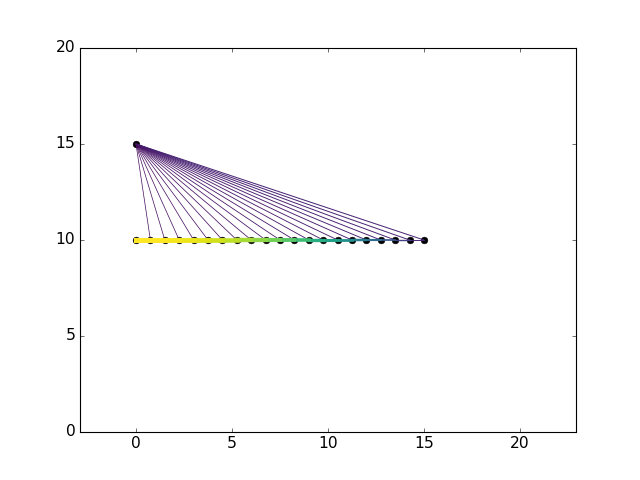

In [64]:
plt.close('all')
f, ax = plt.subplots(1,1)

for node in nodes:
    ax.plot(node.position[0],node.position[1],'ko')
                    
colors = plt.cm.viridis(norm(axial_f))
for i,beam in enumerate(beams):
    ax.plot([beam.vertices[1][0],beam.vertices[0][0]],
            [beam.vertices[1][1],beam.vertices[0][1]],
            c=np.ravel(colors[i]),lw=norm(axial_f)[i]*4+0.5)
    
ax.set_xlim([-5,25])
ax.set_ylim([0,20])
ax.set_aspect('equal', 'datalim')
    
f